In [1]:
# Mean reversion trading strategy

In [2]:
# Import libraries
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime ,timedelta
plt.style.use('fivethirtyeight')

In [3]:
#Connect to MT5
if not mt5.initialize(login=****, server="****",password="*****"):
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [4]:
SYMBOL = "XAGUSD" #Silver
TIMEFRAME = mt5.TIMEFRAME_D1
Start_dt = datetime(2016, 5,1)
end_dt = datetime.now()

In [9]:
# Request data
bars = mt5.copy_rates_range(SYMBOL,TIMEFRAME,Start_dt,end_dt)
df = pd.DataFrame(bars)[['time','open','high','low','close','tick_volume']]
#Set the date as the index
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.set_index(pd.DatetimeIndex(df['time'].values))
df.drop(['time'] , inplace=True ,axis=1)
df

,open,high,low,close,tick_volume
2018-11-14,14.045,14.169,14.004,14.108,7102
2018-11-15,14.117,14.326,14.071,14.265,21413
2018-11-16,14.260,14.396,14.210,14.383,19336
2018-11-19,14.398,14.415,14.325,14.398,14806
2018-11-20,14.404,14.464,14.204,14.292,20037
...,...,...,...,...,...
2022-09-01,17.986,17.995,17.556,17.798,47410
2022-09-02,17.798,18.283,17.777,18.011,43323
2022-09-05,18.032,18.247,17.942,18.157,24635
2022-09-06,18.157,18.581,17.942,18.004,44804


In [11]:
# Function to calculate simple moving average
def SMA(data,period=30 ,column='close'):
    return data[column].rolling(window=period).mean()

In [12]:
#Build and show the data set
df['SMA'] = SMA(df,21)
df['Simple_Returns'] = df.pct_change(1)['close']
df['Log_Returns'] = np.log(1+df['Simple_Returns'])
df['Ratios'] = df['close'] / df['SMA']
#Show data
df

,open,high,low,close,tick_volume,SMA,Simple_Returns,Log_Returns,Ratios
2018-11-14,14.045,14.169,14.004,14.108,7102,NaN,NaN,NaN,NaN
2018-11-15,14.117,14.326,14.071,14.265,21413,NaN,0.011128,0.011067,NaN
2018-11-16,14.260,14.396,14.210,14.383,19336,NaN,0.008272,0.008238,NaN
2018-11-19,14.398,14.415,14.325,14.398,14806,NaN,0.001043,0.001042,NaN
2018-11-20,14.404,14.464,14.204,14.292,20037,NaN,-0.007362,-0.007389,NaN
...,...,...,...,...,...,...,...,...,...
2022-09-01,17.986,17.995,17.556,17.798,47410,19.523143,-0.010453,-0.010508,0.911636
2022-09-02,17.798,18.283,17.777,18.011,43323,19.420714,0.011968,0.011897,0.927412
2022-09-05,18.032,18.247,17.942,18.157,24635,19.338048,0.008106,0.008073,0.938926
2022-09-06,18.157,18.581,17.942,18.004,44804,19.211857,-0.008427,-0.008462,0.937130


In [13]:
# Some statistics
df['Ratios'].describe()

count    966.000000
mean       1.003233
std        0.050441
min        0.721602
25%        0.979495
50%        1.001045
75%        1.027102
max        1.290498
Name: Ratios, dtype: float64

In [16]:
#Get and show the percentile value to know where and when to buy 
percentiles = [15, 20, 50, 80, 85]
#Remove NA Value in the ratios and store the result in ratios
ratios = df['Ratios'].dropna()
#Get the value of percentiles 
percentiles_values = np.percentile(ratios,percentiles)
#show the values
percentiles_values

array([0.96172082, 0.97294205, 1.00104473, 1.0339707 , 1.0443463 ])

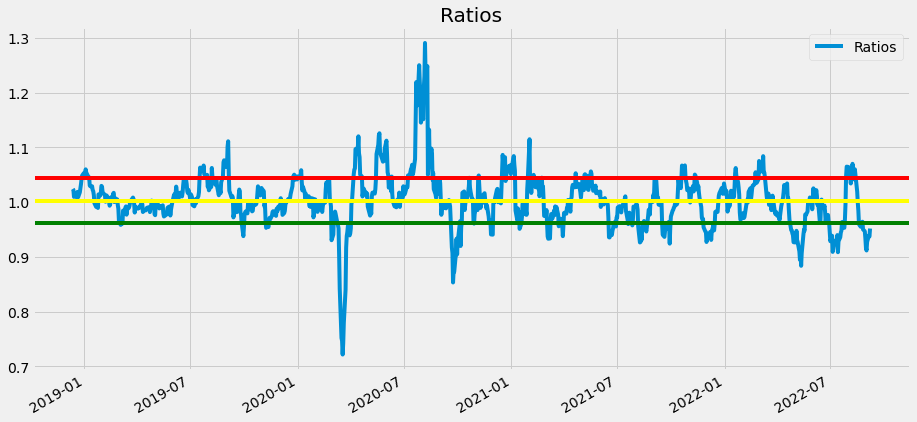

In [41]:
#Plot the ratios
plt.figure(figsize=(14,7))
plt.title('Ratios')
df['Ratios'].dropna().plot(legend=True)
plt.axhline(percentiles_values[0], color='green', label='15th percentile')
plt.axhline(percentiles_values[2], color='yellow', label='50th percentile')
plt.axhline(percentiles_values[-1], color='red', label='85th percentile')

In [42]:
#Create buy and sell signals
sell = percentiles_values[-1] # the 85th percentile threshold where we want to sell
buy = percentiles_values[0] # the 15th percentile threshold where we want to buy
# -1 where the Ratio is greater than the percentile to sell and nan otherwise
df['Positions']= np.where(df.Ratios > sell ,-1 , np.nan)
# 1 where the Ratio is less than the percentile to buy and the current value otherwise
df['Positions'] = np.where(df.Ratios < buy ,1,df['Positions'])
# Use ffill to fill the missing value in the data frame , ffill stand for forward fill
df['Positions'] = df['Positions'].ffill()

#Get the buy and sell signals
df['Buy'] = np.where(df.Positions == 1 ,df['close'], np.nan)
df['Sell'] = np.where(df.Positions == -1 ,df['close'], np.nan)


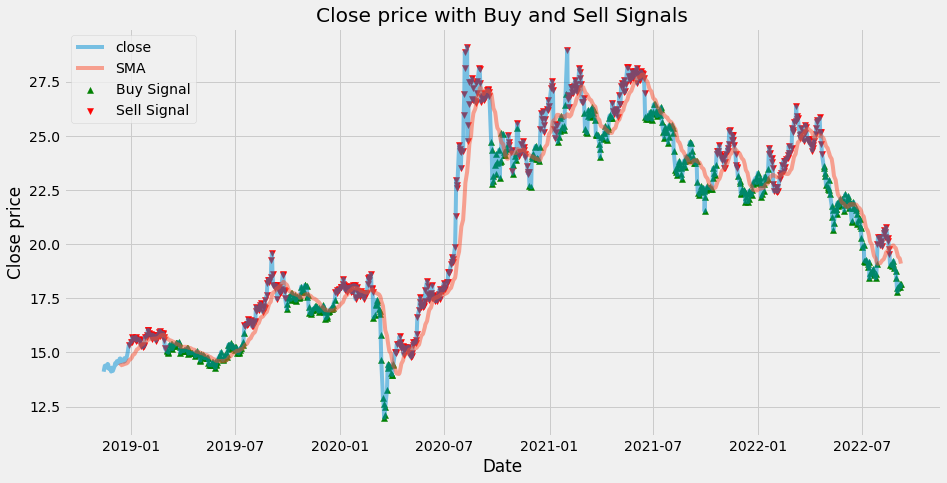

In [43]:
# Visualize the buy and sell signals with close price
plt.figure(figsize=(14,7))
plt.title('Close price with Buy and Sell Signals')
plt.plot(df['close'], alpha=0.5, label='close')
plt.plot(df['SMA'], alpha=0.5, label='SMA')
plt.scatter(df.index, df['Buy'], color='green', label= 'Buy Signal' ,marker='^' ,alpha=1)
plt.scatter(df.index, df['Sell'], color='red', label= 'Sell Signal' ,marker='v' ,alpha=1)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend()
plt.show()

In [44]:
# Calculate the returns for the mean reversion strategy
df['Strategy_Returns'] = df.Positions.shift(1) * df.Log_Returns
df['Strategy_Returns']

2018-11-14         NaN
2018-11-15         NaN
2018-11-16         NaN
2018-11-19         NaN
2018-11-20         NaN
                ...   
2022-09-01   -0.010508
2022-09-02    0.011897
2022-09-05    0.008073
2022-09-06   -0.008462
2022-09-07    0.009563
Name: Strategy_Returns, Length: 986, dtype: float64

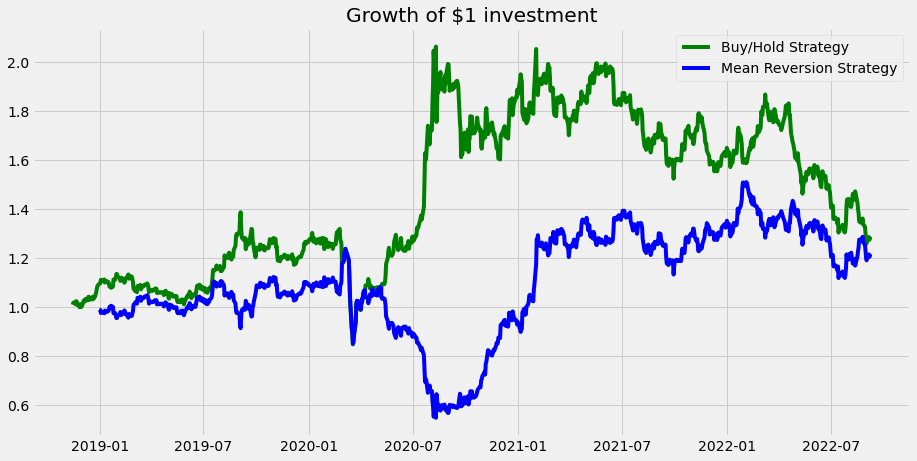

In [45]:
#Plot the cumulative log returns and the cumulative mean reversion strategy
plt.figure(figsize=(14,7))
plt.title('Growth of $1 investment')
plt.plot(np.exp(df['Log_Returns'].dropna()).cumprod(), c='green',label= 'Buy/Hold Strategy')
plt.plot(np.exp(df['Strategy_Returns'].dropna()).cumprod(), c='blue',label= 'Mean Reversion Strategy')
plt.legend()


In [46]:
# Print the return for both strategies
print('Buy & Hold Strategy Returns:', np.exp(df['Log_Returns'].dropna()).cumprod()[-1] -1)
print('Mean Reversion Strategy Returns:', np.exp(df['Strategy_Returns'].dropna()).cumprod()[-1] -1)

Buy & Hold Strategy Returns: 0.2884179189112539
Mean Reversion Strategy Returns: 0.21774600648350617
